<a href="https://colab.research.google.com/github/ris0801/Generalization-DeepLearning/blob/main/AdvancedProject_Figure1_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
# Check for CUDA availability and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Input size: [3, 32, 32]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1) # Output size: [16, 32, 32]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # Output size: [16, 16, 16]
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # Output size: [32, 16, 16]
        # Another max pooling will reduce size to [32, 8, 8]
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [ ]:
def misclassification_rate(model, loader):
    correct = np.zeros(len(loader.dataset))
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct_batch = pred.eq(target.view_as(pred)).squeeze().cpu().numpy()
            # Update the correct array
            for i in range(len(correct_batch)):
                correct[i] += correct_batch[i]
    return correct


In [ ]:
def estimated_p_correct(model, loader):
    correct = np.zeros(len(loader.dataset))
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct[batch_idx * loader.batch_size:batch_idx * loader.batch_size + len(data)] = pred.eq(target).cpu().numpy().astype(int)
    return correct


In [ ]:
num_sample_points = 1000

In [ ]:
num_initializations = 50
all_p_corrects = np.zeros(1000)

for _ in range(num_initializations):
    model = SimpleCNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # random_indices = random.sample(range(len(train_dataset)), 1000)
    # subset_dataset = torch.utils.data.Subset(train_dataset, random_indices)
    # train_loader_subset = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=True)

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    random_indices = random.sample(range(len(train_dataset)), num_sample_points)
    subset_dataset = torch.utils.data.Subset(train_dataset, random_indices)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False)

    all_p_corrects += estimated_p_correct(model, subset_loader)


all_p_corrects /= num_initializations


In [ ]:
sorted_p_correct = np.sort(all_p_corrects)

In [ ]:
# randX: Replace the input with Gaussian noise
# Convert the dataset to the expected format and then create randX_data
formatted_data = np.transpose(train_dataset.data, (0, 3, 1, 2))  # [N, 3, 32, 32]
randX_data = torch.randn_like(torch.tensor(formatted_data, dtype=torch.float)) / 255.
randX_dataset = torch.utils.data.TensorDataset(randX_data, torch.tensor(train_dataset.targets))
randX_loader = torch.utils.data.DataLoader(randX_dataset, batch_size=64, shuffle=True)

In [ ]:
num_initializations = 50
all_p_corrects_randx = np.zeros(1000)

for _ in range(num_initializations):
    model = SimpleCNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # random_indices = random.sample(range(len(train_dataset)), 1000)
    # subset_dataset = torch.utils.data.Subset(randX_dataset, random_indices)
    # train_loader_subset = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=True)

    for data, target in randX_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    random_indices = random.sample(range(len(randX_data)), num_sample_points)
    subset_dataset = torch.utils.data.Subset(randX_dataset, random_indices)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False)

    all_p_corrects_randx += estimated_p_correct(model, subset_loader)

all_p_corrects_randx /= num_initializations

In [ ]:
sorted_p_correct_randx = np.sort(all_p_corrects_randx)

In [ ]:
# Convert the numpy data to a tensor and transpose to the correct shape
formatted_data_tensor = torch.tensor(np.transpose(train_dataset.data, (0, 3, 1, 2)), dtype=torch.float) / 255.

# Generate random labels for the data
randY_labels = torch.tensor(np.random.randint(0, 10, len(train_dataset)), dtype=torch.long)

# Create a TensorDataset using original data and random labels
randY_dataset = torch.utils.data.TensorDataset(formatted_data_tensor, randY_labels)
randY_loader = torch.utils.data.DataLoader(randY_dataset, batch_size=64, shuffle=True)

In [ ]:
num_initializations = 50
all_p_corrects_randy = np.zeros(1000)

for _ in range(num_initializations):
    model = SimpleCNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Choose a random subset of 1000 samples
    # random_indices = random.sample(range(len(randY_dataset)), 1000)
    # subset_dataset = torch.utils.data.Subset(randY_dataset, random_indices)
    # train_loader_subset = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=True)

    for data, target in randY_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    random_indices = random.sample(range(len(randY_dataset)), num_sample_points)
    subset_dataset = torch.utils.data.Subset(randY_dataset, random_indices)
    subset_loader = torch.utils.data.DataLoader(subset_dataset, batch_size=64, shuffle=False)

    all_p_corrects_randy += estimated_p_correct(model, subset_loader)

all_p_corrects_randy /= num_initializations

In [ ]:
sorted_p_correct_randy = np.sort(all_p_corrects_randy)

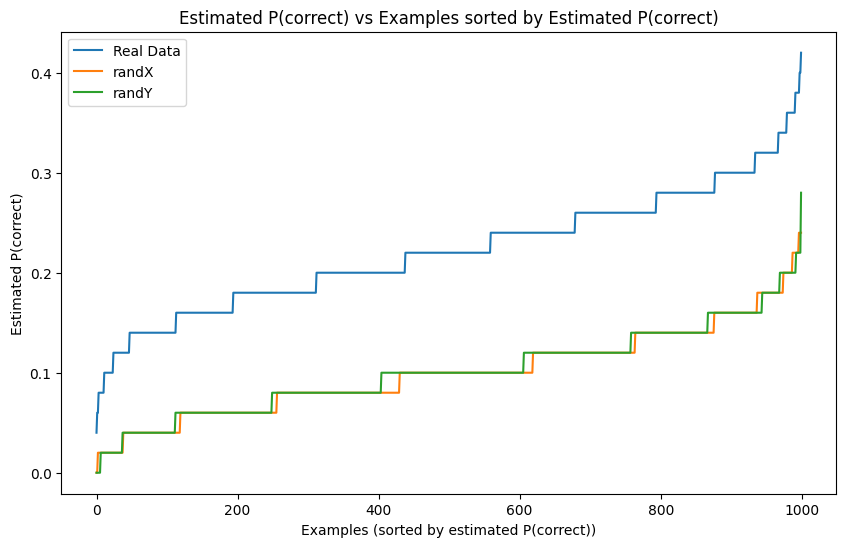

In [ ]:
plt.figure(figsize=(10,6))

# Plotting each dataset
plt.plot(sorted_p_correct, label="Real Data")
plt.plot(sorted_p_correct_randx, label="randX")
plt.plot(sorted_p_correct_randy, label="randY")

# Setting labels, title, and legend
plt.xlabel('Examples (sorted by estimated P(correct))')
plt.ylabel('Estimated P(correct)')
plt.legend()
plt.title("Estimated P(correct) vs Examples sorted by Estimated P(correct)")

# Display the plot
plt.show()
